In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [3]:
df = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/911_calls/911_calls_clean.csv')
weather = pd.read_csv('https://storage.googleapis.com/cs163-seniorproject.appspot.com/dataset/weather/weather_clean.csv')
df = pd.merge(df, weather, left_on = 'OFFENSE_DATE', right_on='DATE', how = 'left')
df = df.drop(columns = ['DATE'])
df = df.drop(columns = ['STATION'])

df.head()

,Unnamed: 0,PRIORITY,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO,ADDRESS,CITY,STATE,...,WDF5,WSF2,WSF5,FOG,HEAVY_FOG,THUNDER,HAIL,SMOKE_HAZE,MIST,RAIN
0,0,4,2013-01-01,00:00:06,415FC,Public Disturbances,No Action or Unresolved,UTOPIA PL & PEAK DR,San Jose,CA,...,20.0,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4,2013-01-01,00:01:05,1062,Community Policing,No Action or Unresolved,QUIMBY RD & S WHITE RD,San Jose,CA,...,20.0,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2,2013-01-01,00:02:01,1057,Weapons Related,No Action or Unresolved,[3500]-[3600] PAYNE AV,San Jose,CA,...,20.0,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2,2013-01-01,00:02:43,1057,Weapons Related,No Action or Unresolved,[800]-[900] SAKURA DR,San Jose,CA,...,20.0,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4,2013-01-01,00:02:49,415FC,Public Disturbances,No Action or Unresolved,VINEYARD DR & SANTA TERESA BL,San Jose,CA,...,20.0,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


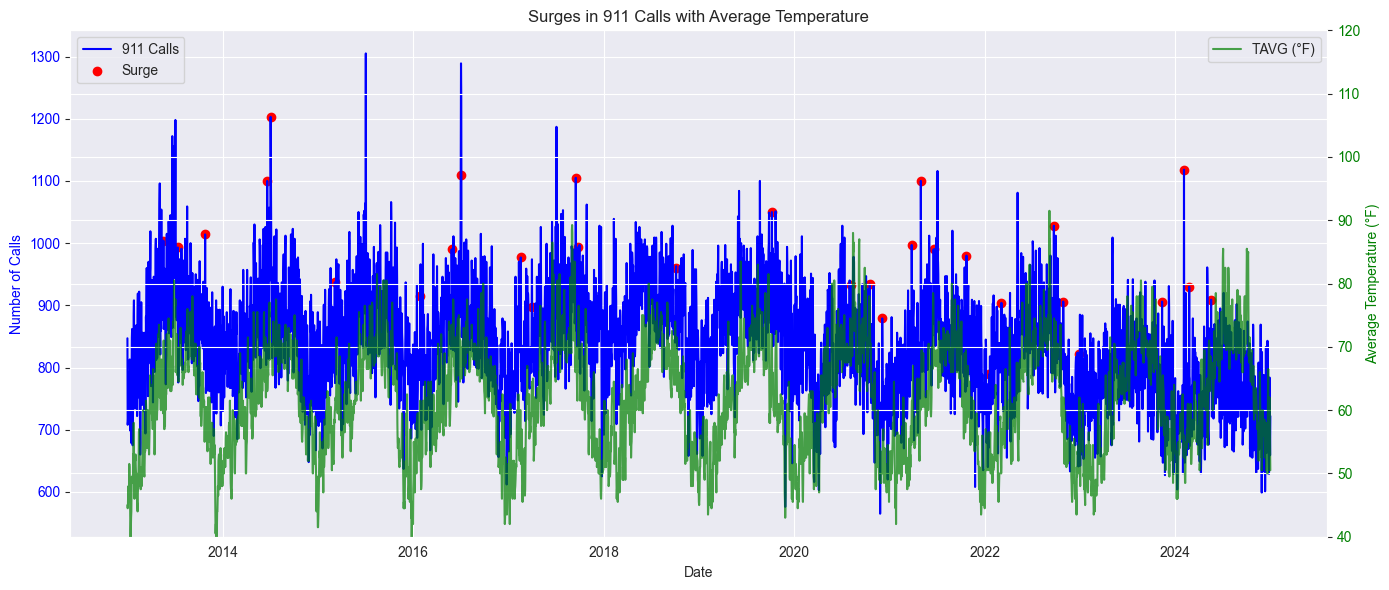

In [4]:
daily_calls = df
daily_calls['OFFENSE_DATE'] = pd.to_datetime(daily_calls['OFFENSE_DATE'])
daily_calls.set_index('OFFENSE_DATE', inplace = True)
daily_calls = daily_calls.resample('D').size().rename('CALL_COUNT').to_frame()

# drop outliers
mean_call_count = daily_calls[daily_calls['CALL_COUNT'] >= 400]['CALL_COUNT'].mean()
daily_calls['CALL_COUNT'] = daily_calls['CALL_COUNT'].apply(lambda x: mean_call_count if x < 400 else x)

daily_calls['ROLLING_MEAN'] = daily_calls['CALL_COUNT'].rolling(window = 7).mean()
daily_calls['ROLLING_STD'] = daily_calls['CALL_COUNT'].rolling(window = 7).std()

daily_calls['TAVG'] = df['TAVG'].resample('D').mean()

daily_calls['SURGE'] = daily_calls['CALL_COUNT'] > (daily_calls['ROLLING_MEAN'] + 2 * daily_calls['ROLLING_STD'])

fig,ax1 = plt.subplots(figsize = (14, 6))

ax1.plot(daily_calls.index, daily_calls['CALL_COUNT'], label = '911 Calls', color = 'blue')
ax1.scatter(daily_calls[daily_calls['SURGE']].index,
            daily_calls[daily_calls['SURGE']]['CALL_COUNT'],
            color = 'red', label = 'Surge')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Calls', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Add TAVG to the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(daily_calls.index, daily_calls['TAVG'], label='TAVG (°F)', color='green', alpha=0.7)
ax2.set_ylabel('Average Temperature (°F)', color='green')
ax2.set_ylim(40,120)
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Title and layout
plt.title('Surges in 911 Calls with Average Temperature')
plt.tight_layout()
plt.show()

/var/folders/rk/pqkf6b3d2pvdw7l0_7hs338c0000gn/T/ipykernel_40804/2258485680.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')
/var/folders/rk/pqkf6b3d2pvdw7l0_7hs338c0000gn/T/ipykernel_40804/2258485680.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


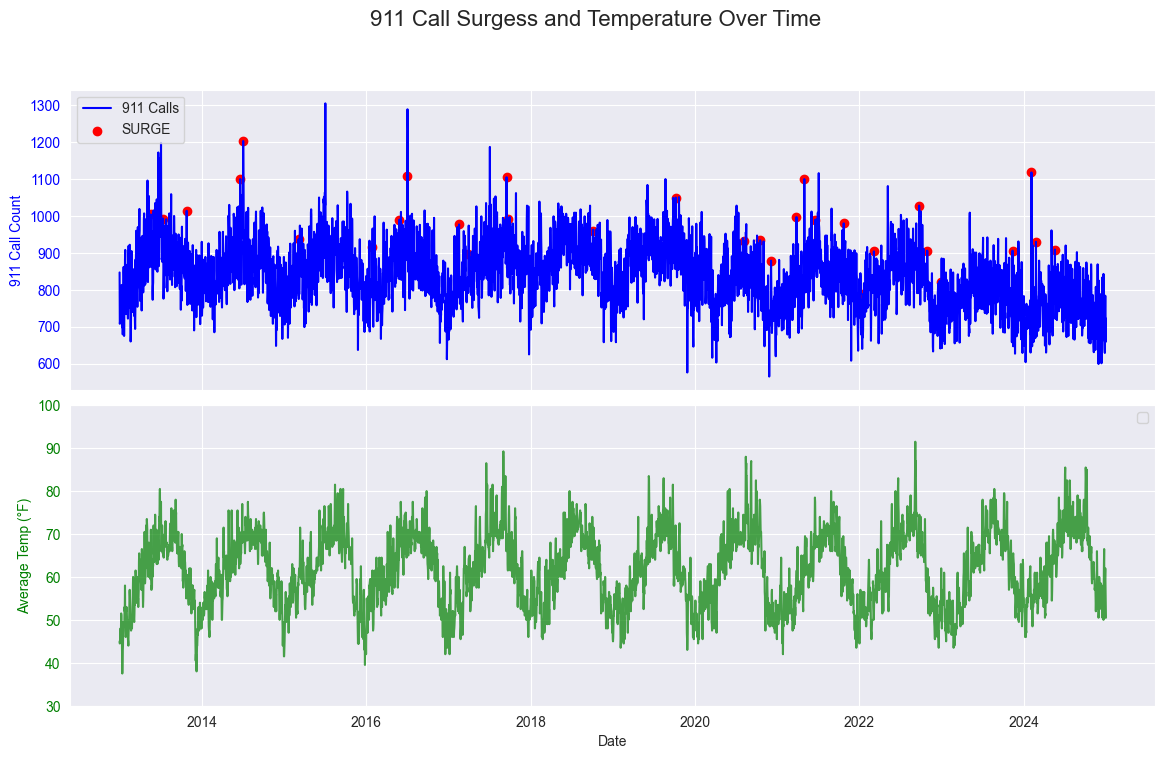

In [5]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1], hspace = 0.05)
ax1 = fig.add_subplot(gs[0])
ax1.plot(daily_calls.index, daily_calls['CALL_COUNT'], label='911 Calls', color='blue')
ax1.scatter(daily_calls[daily_calls['SURGE']].index,
            daily_calls[daily_calls['SURGE']]['CALL_COUNT'],
            color='red', label='SURGE')
ax1.set_ylabel('911 Call Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.tick_params(labelbottom=False)

# Bottom plot: Temperature
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_calls.index, daily_calls['TAVG'], color='green', alpha=0.7)
ax2.set_ylabel('Average Temp (°F)', color='green')
ax2.set_ylim(30, 100)
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')
# Shared X-axis
ax2.set_xlabel('Date')

# Title
fig.suptitle('911 Call Surgess and Temperature Over Time', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


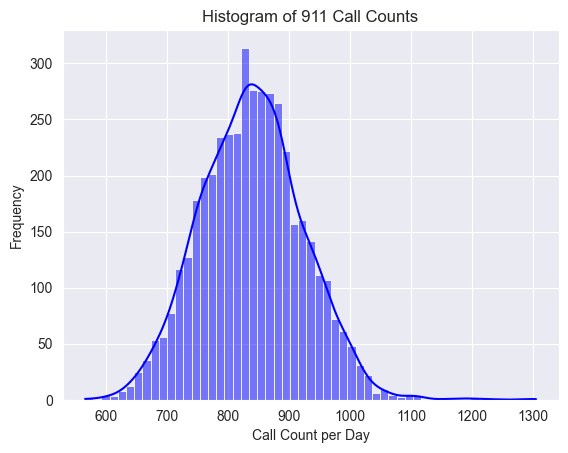

In [6]:
sns.histplot(daily_calls['CALL_COUNT'], kde = True, color = 'blue')
plt.title('Histogram of 911 Call Counts')
plt.xlabel('Call Count per Day')
plt.ylabel('Frequency')
plt.show()

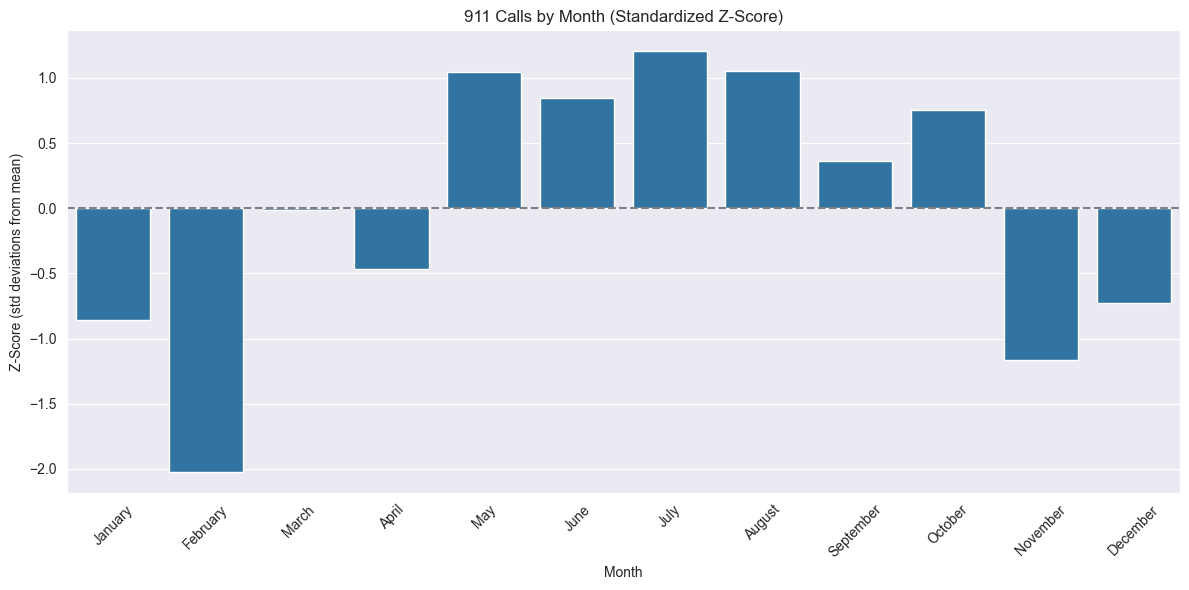

In [7]:
df = df.reset_index()
df['OFFENSE_DATE'] = pd.to_datetime(df['OFFENSE_DATE'])

df['Month'] = df['OFFENSE_DATE'].dt.month_name()

month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_totals = df.groupby('Month').size().reindex(month_order)

monthly_z = zscore(monthly_totals)

plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_totals.index, y=monthly_z)
plt.title('911 Calls by Month (Standardized Z-Score)')
plt.ylabel('Z-Score (std deviations from mean)')
plt.xlabel('Month')
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
!pip install statsmodels


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


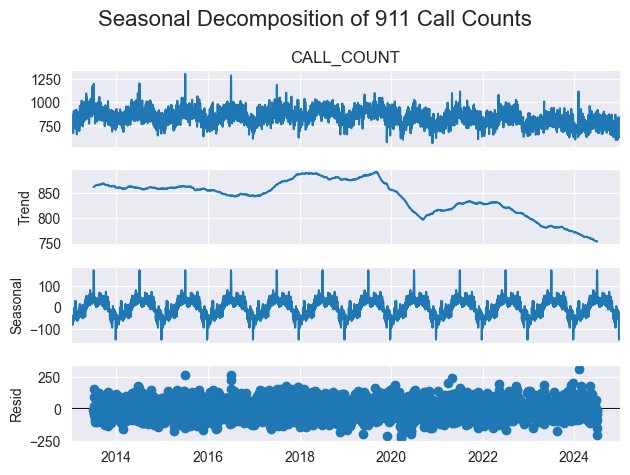

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(daily_calls['CALL_COUNT'], model='additive', period=365)

# Plot the decomposition
result.plot()
plt.suptitle('Seasonal Decomposition of 911 Call Counts', fontsize=16)
plt.tight_layout()
plt.show()

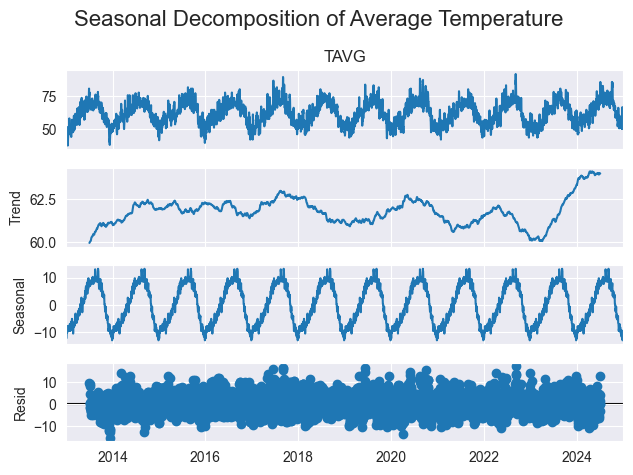

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Handle missing values in TAVG
daily_calls['TAVG'] = daily_calls['TAVG'].interpolate(method='time')

# Perform seasonal decomposition
result = seasonal_decompose(daily_calls['TAVG'], model='additive', period=365)

# Plot the decomposition
result.plot()
plt.suptitle('Seasonal Decomposition of Average Temperature', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
correlation = daily_calls['CALL_COUNT'].corr(daily_calls['TAVG'])
print(f"Correlation between CALL_COUNT and TAVG: {correlation}")

Correlation between CALL_COUNT and TAVG: 0.4119824864585065


In [12]:
daily_calls['TAVG_LAG1'] = daily_calls['TAVG'].shift(1)
correlation_lag = daily_calls['CALL_COUNT'].corr(daily_calls['TAVG_LAG1'])
print(f"Correlation with lagged temperature: {correlation_lag}")

Correlation with lagged temperature: 0.39877075279099733


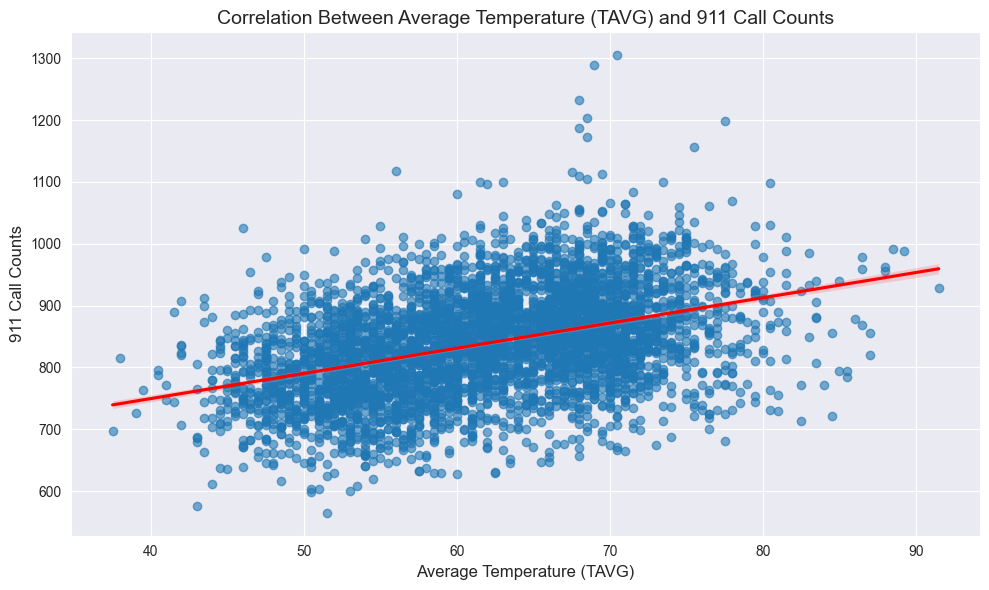

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x=daily_calls['TAVG'], 
    y=daily_calls['CALL_COUNT'], 
    scatter_kws={'alpha': 0.6}, 
    line_kws={'color': 'red'}
)

# Add labels and title
plt.title('Correlation Between Average Temperature (TAVG) and 911 Call Counts', fontsize=14)
plt.xlabel('Average Temperature (TAVG)', fontsize=12)
plt.ylabel('911 Call Counts', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

TEMP_BIN
Cold    778.581731
Mild    837.413121
Warm    877.150599
Hot     928.000000
Name: CALL_COUNT, dtype: float64


/var/folders/rk/pqkf6b3d2pvdw7l0_7hs338c0000gn/T/ipykernel_40804/191392581.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_group = daily_calls.groupby('TEMP_BIN')['CALL_COUNT'].mean()


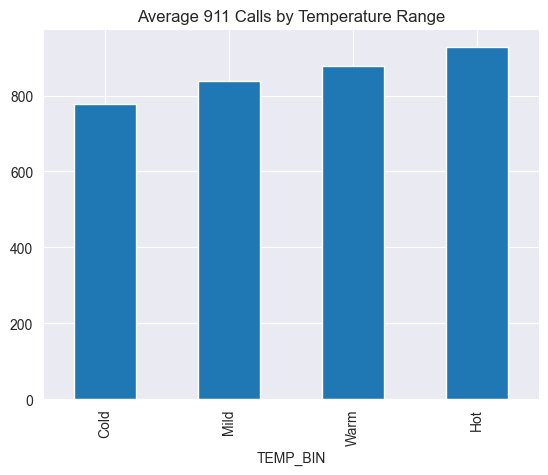

In [14]:
daily_calls['TEMP_BIN'] = pd.cut(daily_calls['TAVG'], bins=[30, 50, 70, 90, 110], labels=['Cold', 'Mild', 'Warm', 'Hot'])
temp_group = daily_calls.groupby('TEMP_BIN')['CALL_COUNT'].mean()
print(temp_group)
temp_group.plot(kind='bar')
plt.title('Average 911 Calls by Temperature Range')
plt.show()

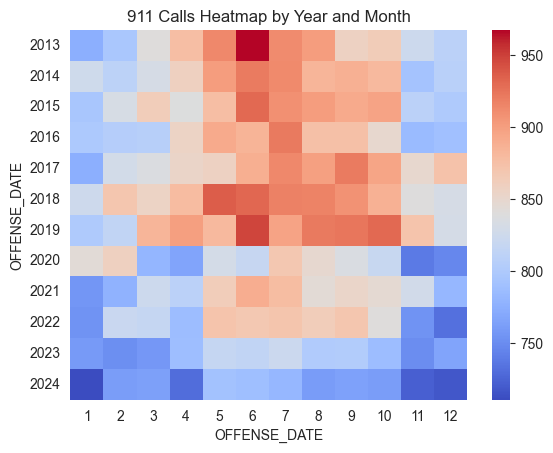

In [15]:
pivot_table = daily_calls.pivot_table(index=daily_calls.index.year, columns=daily_calls.index.month, values='CALL_COUNT', aggfunc='mean')
sns.heatmap(pivot_table, cmap='coolwarm', annot=False)
plt.title('911 Calls Heatmap by Year and Month')
plt.show()

In [16]:
# Compare during the week
df

,OFFENSE_DATE,Unnamed: 0,PRIORITY,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO,ADDRESS,CITY,STATE,...,WSF2,WSF5,FOG,HEAVY_FOG,THUNDER,HAIL,SMOKE_HAZE,MIST,RAIN,Month
0,2013-01-01,0,4,00:00:06,415FC,Public Disturbances,No Action or Unresolved,UTOPIA PL & PEAK DR,San Jose,CA,...,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,January
1,2013-01-01,1,4,00:01:05,1062,Community Policing,No Action or Unresolved,QUIMBY RD & S WHITE RD,San Jose,CA,...,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,January
2,2013-01-01,2,2,00:02:01,1057,Weapons Related,No Action or Unresolved,[3500]-[3600] PAYNE AV,San Jose,CA,...,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,January
3,2013-01-01,3,2,00:02:43,1057,Weapons Related,No Action or Unresolved,[800]-[900] SAKURA DR,San Jose,CA,...,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,January
4,2013-01-01,4,4,00:02:49,415FC,Public Disturbances,No Action or Unresolved,VINEYARD DR & SANTA TERESA BL,San Jose,CA,...,8.9,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3670173,2024-12-31,276064,3,23:48:36,1033A,Alarms and 911 Calls,No Action or Unresolved,[4100]-[4200] MONTEREY RD,San Jose,CA,...,12.1,14.1,0.0,0.0,0.0,NaN,0.0,NaN,NaN,December
3670174,2024-12-31,276065,2,23:48:40,415,Public Disturbances,No Action or Unresolved,[1700]-[1800] TULLY RD,San Jose,CA,...,12.1,14.1,0.0,0.0,0.0,NaN,0.0,NaN,NaN,December
3670175,2024-12-31,276066,4,23:50:27,415M,Public Disturbances,No Action or Unresolved,[1100]-[1200] ROYAL CREST DR,San Jose,CA,...,12.1,14.1,0.0,0.0,0.0,NaN,0.0,NaN,NaN,December
3670176,2024-12-31,276067,3,23:57:51,415F,Public Disturbances,Report Related Outcomes,[2700]-[2800] STORY RD,San Jose,CA,...,12.1,14.1,0.0,0.0,0.0,NaN,0.0,NaN,NaN,December


In [17]:
df['year'] = df['OFFENSE_DATE'].dt.year
df['month'] = df['OFFENSE_DATE'].dt.month
df['day_of_week'] = df['OFFENSE_DATE'].dt.day_name()


In [18]:
df['day_of_week'] = pd.Categorical(df['day_of_week'], 
                                    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                    ordered=True)


In [19]:
weekly_trends = df.groupby(['year', 'month', 'day_of_week']).size().reset_index(name='call_count')


/var/folders/rk/pqkf6b3d2pvdw7l0_7hs338c0000gn/T/ipykernel_40804/3787641098.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekly_trends = df.groupby(['year', 'month', 'day_of_week']).size().reset_index(name='call_count')


/var/folders/rk/pqkf6b3d2pvdw7l0_7hs338c0000gn/T/ipykernel_40804/2744953877.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = weekly_trends.pivot_table(index='day_of_week', columns='month', values='call_count', aggfunc='mean')


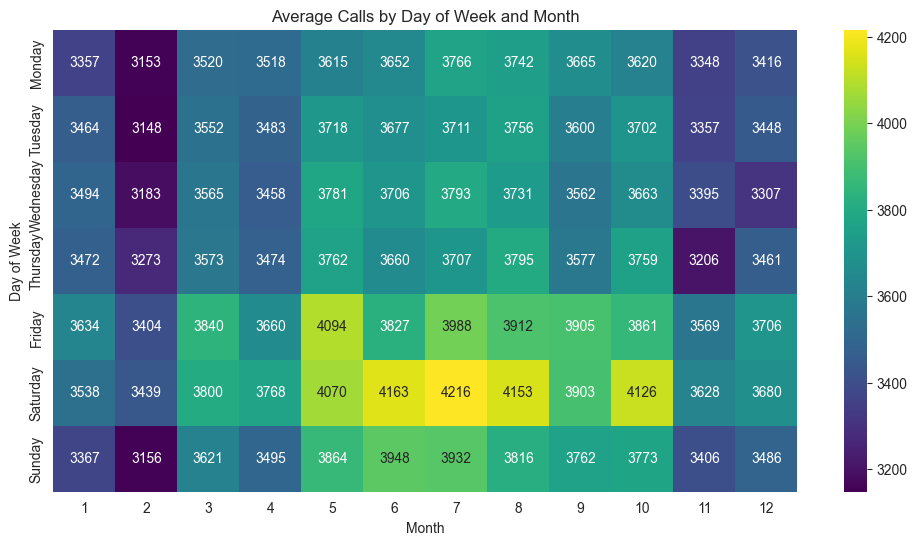

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot for heatmap
pivot_table = weekly_trends.pivot_table(index='day_of_week', columns='month', values='call_count', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='viridis')
plt.title('Average Calls by Day of Week and Month')
plt.ylabel('Day of Week')
plt.xlabel('Month')
plt.show()
